# **Predicting Health Insurance Coverage: A Data Science Approach**

## **Group Information**

- Group G

- Group Members:
    - Daniel Moreira Carneiro (up202108832) 
    - Eduardo Martins Oliveira (up202108690)
    - Gonçalo Bessa Costa (up202108814)

## **Introduction**

Health insurance is a critical aspect of individual financial and physical well-being, especially in the United States, where healthcare costs are significant. 

This project aims to develop a **predictive model to identify whether an individual has health insurance or not**. The notebook follows a comprehensive and typical data science process.

## **Project Key Contributions and Insights**

- The dataset was **very imbalanced**, with most people having health insurance. As expected, initial modeling showed **high performance for Class 1** (people with insurance) and **very low performance for Class 0** (people without insurance).
- In a real-world context, it is more important to **identify people without insurance**, so we focused on **recall for Class 0** as the main metric.
- Using **PCA**, we visualized the class distribution and observed a **high overlap between the two classes**. This showed it would be **hard to build a highly accurate model**, which was confirmed in the **Kaggle competition results**.
- To address the imbalance, we tested several techniques. The best results were achieved using **SMOTETomek** and a combination of **SMOTETomek with EditedNearestNeighbours (ENN)**. **ENN** was particularly useful in **reducing class overlap** by removing ambiguous samples near the decision boundary.
- After applying these resampling techniques, we observed a **significant improvement in performance for Class 0**, with recall for the minority class increasing considerably.
- After testing different models, **XGBoost with SMOTETomek** gave the **best performance** in the competition.
- Models like **Decision Tree** and **Random Forest** performed well on the training data but did not generalize well to the test set, showing signs of **overfitting**.

---

## **Data Understanding**

To begin the data science process, we explored the dataset to gain insights into its structure, quality, and potential relationships between variables. This step is crucial for identifying any issues or patterns that could influence model performance.

### **Importing Libraries**

In [825]:
# Standard library 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from collections import Counter

# Scikit-learn 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, roc_auc_score, accuracy_score, precision_score, precision_recall_curve)
from sklearn.model_selection import (cross_val_score, RandomizedSearchCV, train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Imbalanced-learn 
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter

# XGBoost 
from xgboost import XGBClassifier

# Define a custom color palette
custom_palette = ['#63783D', '#CFE0BC']

# Set the custom color palette for seaborn plots
sns.set_palette(custom_palette)

# warinings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

### **Loading the Data**

In [826]:
df = pd.read_csv('../data/customer.csv')

df.head()

Unnamed: 0        custid     sex is_employed   income      marital_status  \
0           7  000006646_03    Male        True  22000.0       Never married   
1           8  000007827_01  Female         NaN  23200.0  Divorced/Separated   
2           9  000008359_04  Female        True  21000.0       Never married   
3          10  000008529_01  Female         NaN  37770.0             Widowed   
4          11  000008744_02    Male        True  39000.0  Divorced/Separated   

   health_ins                  housing_type  num_vehicles  age state_of_res  \
0        True      Homeowner free and clear           0.0   24      Alabama   
1        True                        Rented           0.0   82      Alabama   
2        True  Homeowner with mortgage/loan           2.0   31      Alabama   
3        True      Homeowner free and clear           1.0   93      Alabama   
4        True                        Rented           2.0   67      Alabama   

   code_column  gas_usage  rooms recent_move_b  
0         1047      210.0      3             F  
1         1047        3.0      6             T  
2         1047       40.0      3             F  
3         1047      120.0      2             F  
4         1047        3.0      2             F

### **Data Overview**

In [827]:
df.shape

(72458, 15)

In [828]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72458 non-null  int64  
 1   custid          72458 non-null  object 
 2   sex             72458 non-null  object 
 3   is_employed     46943 non-null  object 
 4   income          72458 non-null  float64
 5   marital_status  72458 non-null  object 
 6   health_ins      72458 non-null  bool   
 7   housing_type    70772 non-null  object 
 8   num_vehicles    70772 non-null  float64
 9   age             72458 non-null  int64  
 10  state_of_res    72458 non-null  object 
 11  code_column     72458 non-null  int64  
 12  gas_usage       70772 non-null  float64
 13  rooms           72458 non-null  int64  
 14  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 7.8+ MB


In [829]:
# Display summary statistics of the DataFrame
df.describe()

Unnamed: 0        income  num_vehicles           age   code_column  \
count   72458.000000  7.245800e+04  70772.000000  72458.000000  72458.000000   
mean    49910.637556  4.188143e+04      2.066820     49.208893   3285.523572   
std     28772.082702  5.827460e+04      1.170076     18.090035   2661.775225   
min         7.000000 -6.900000e+03      0.000000      0.000000    131.000000   
25%     24911.250000  1.070000e+04      1.000000     34.000000   1305.000000   
50%     49838.000000  2.640000e+04      2.000000     48.000000   2269.000000   
75%     74786.750000  5.200000e+04      3.000000     62.000000   4979.000000   
max    100000.000000  1.257000e+06      6.000000    120.000000   8962.000000   

          gas_usage         rooms  
count  70772.000000  72458.000000  
mean      41.230501      3.494549  
std       63.149323      1.706537  
min        1.000000      1.000000  
25%        3.000000      2.000000  
50%       10.000000      3.000000  
75%       60.000000      5.000000  
max      570.000000      6.000000

In [830]:
# Print the number of null values for each column
print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
Unnamed: 0            0
custid                0
sex                   0
is_employed       25515
income                0
marital_status        0
health_ins            0
housing_type       1686
num_vehicles       1686
age                   0
state_of_res          0
code_column           0
gas_usage          1686
rooms                 0
recent_move_b      1687
dtype: int64


In [831]:
# Print the number of duplicate rows
print("\nDuplicate rows:")
print(df.duplicated().sum())


Duplicate rows:
0


In [832]:
# Print the number of unique values for each column
print("\nUnique values per column:")
print(df.nunique())


Unique values per column:
Unnamed: 0        72458
custid            72458
sex                   2
is_employed           2
income             4445
marital_status        4
health_ins            2
housing_type          4
num_vehicles          7
age                  81
state_of_res         51
code_column          49
gas_usage            57
rooms                 6
recent_move_b         2
dtype: int64


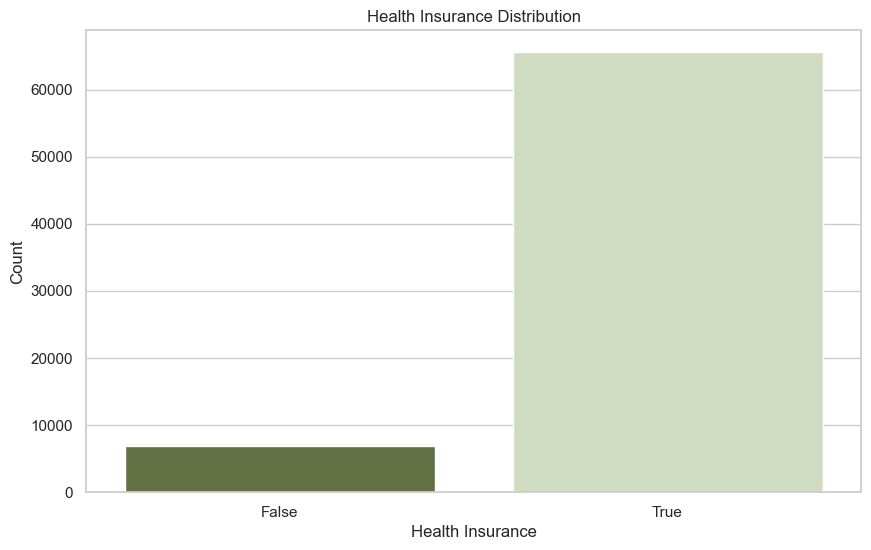

In [833]:
# Health Insurance Distribution
health_ins_counts = df['health_ins'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=health_ins_counts.index, y=health_ins_counts.values, palette=custom_palette)
plt.xlabel('Health Insurance')
plt.ylabel('Count')
plt.title('Health Insurance Distribution')
plt.show()

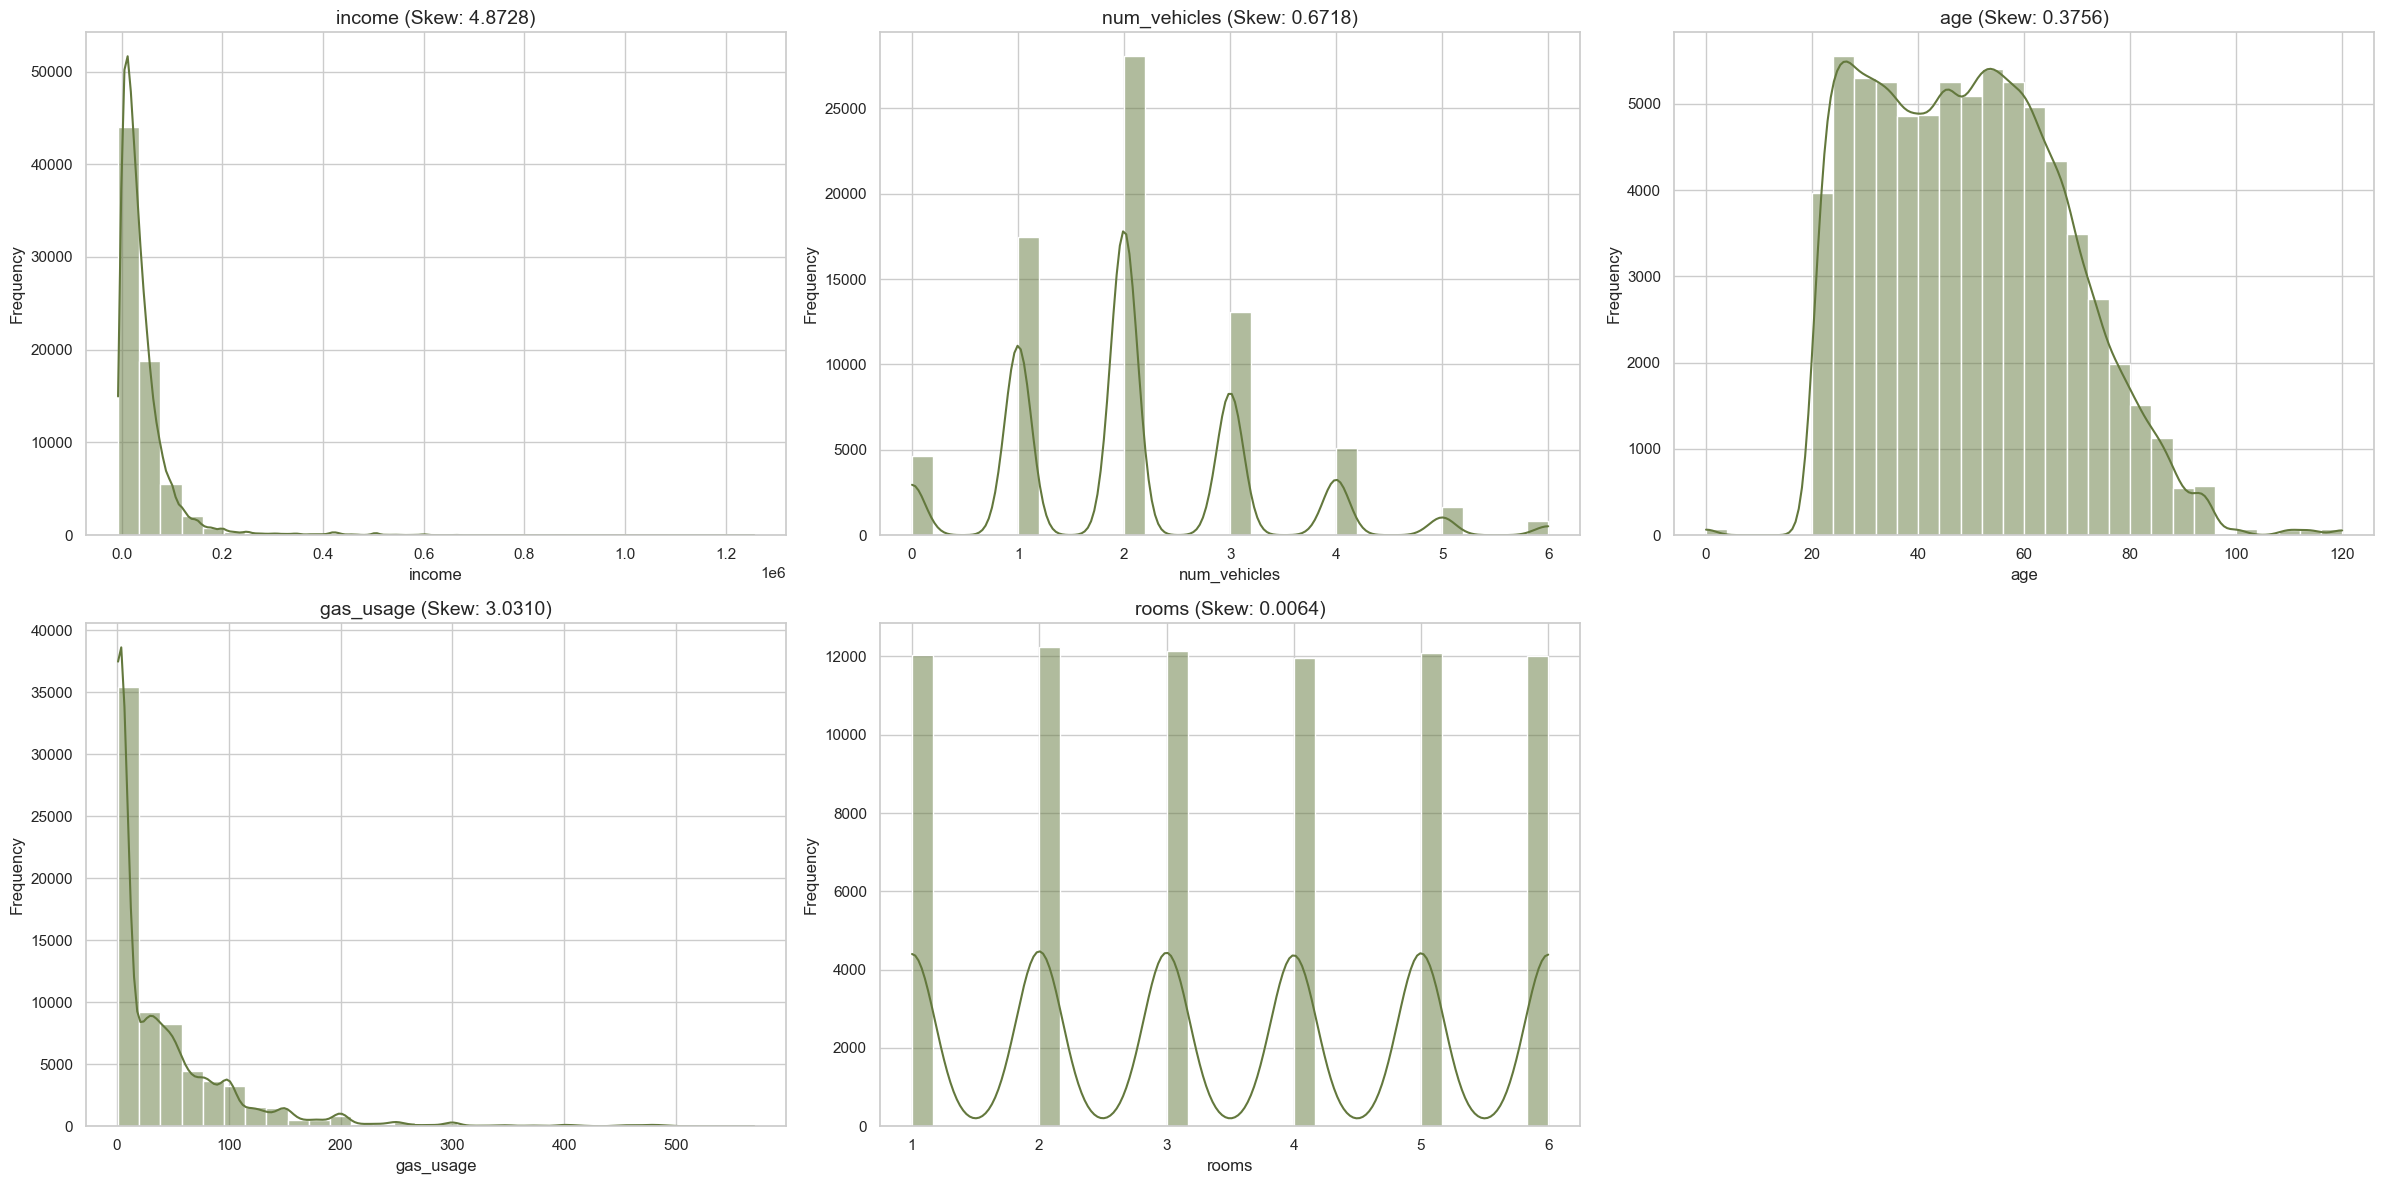

In [834]:
# List of numerical features to plot
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms']

color = custom_palette[0]

f, axes = plt.subplots(2, 3, figsize=(24, 12)) 
axes = axes.flatten()  

# Iterate over the numerical features and create a histogram for each
for i, col in enumerate(df[numerical_features].columns):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color=color)  
    axes[i].set_title(f'{col} (Skew: {df[col].skew():.4f})', fontsize=14)  
    axes[i].set_xlabel(col, fontsize=12)  
    axes[i].set_ylabel('Frequency', fontsize=12)  

for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()

plt.show()

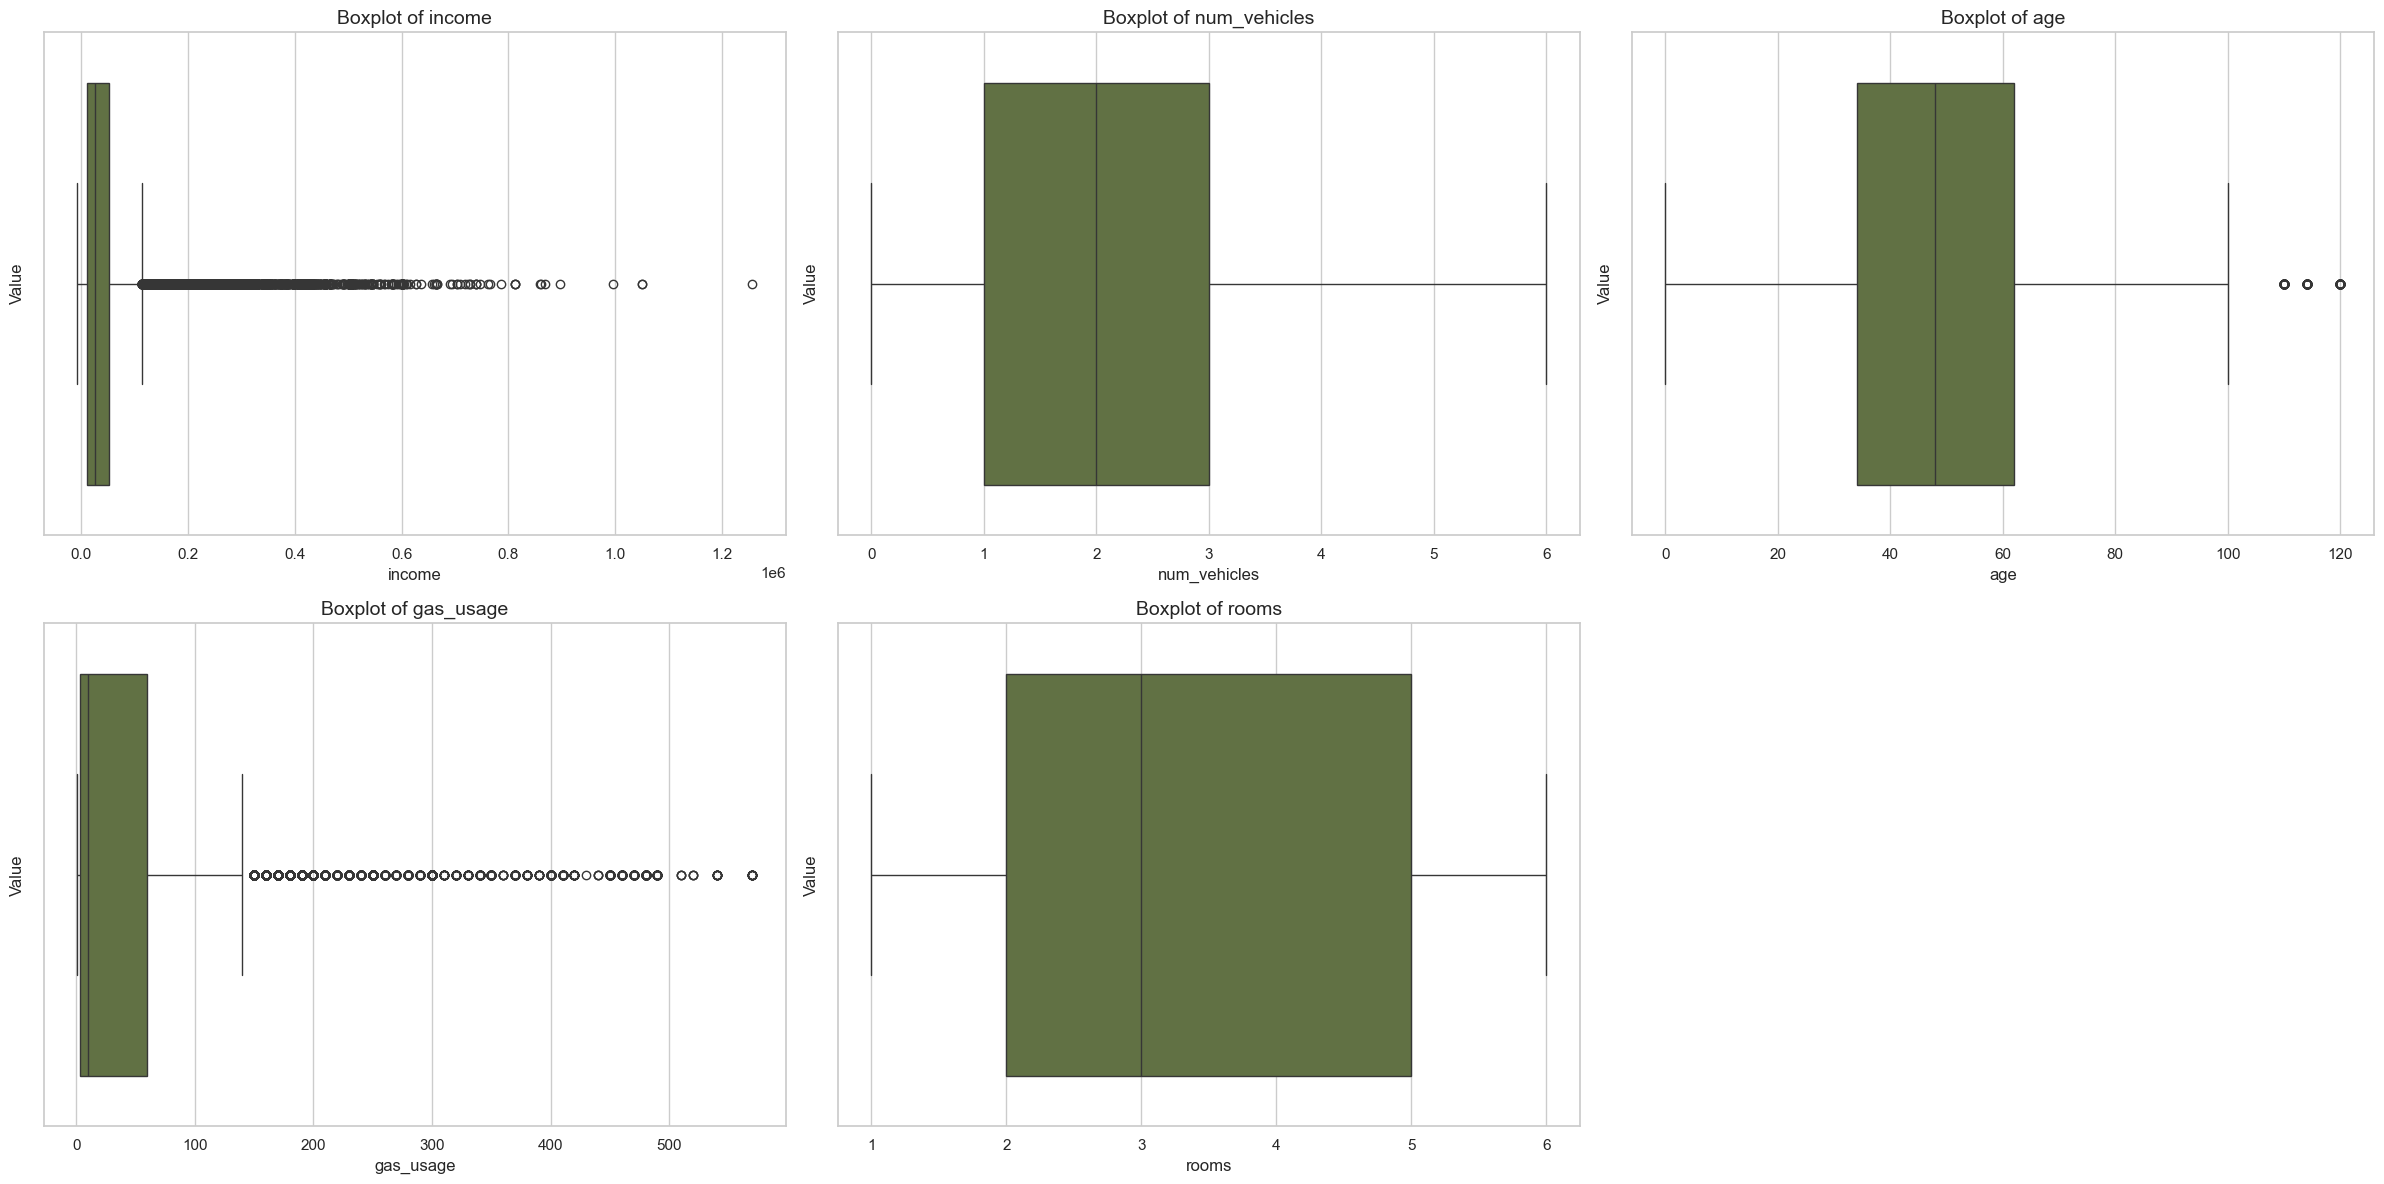

In [835]:
sns.set_theme(style="whitegrid")

f, axes = plt.subplots(2, 3, figsize=(24, 12))  
axes = axes.flatten()

# Iterate over the numerical features and create a boxplot for each
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i], color=color)
    axes[i].set_title(f'Boxplot of {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Value', fontsize=12)

for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **Key Insights from Data Understanding**
> 
> 1. The dataset has a reasonable number of observations (**72458**) and **15** features.
> 2. The **target variable** is `health_ins` (1 if the individual has health insurance, 0 otherwise).
> 3. The dataset contains a **mix of numerical and categorical features**. We might need to encode the categorical features before building the model.
> 4. There are **some missing values** in the dataset. 
> 5. There are **no duplicate rows** in the dataset.
> 6. There are **some outliers** in the dataset, especially in the `income` and `gas_usage` columns, but also in `age`. We can observe this by looking at the distribution plots and the box plots. 
> 7. The **dataset is imbalanced**, with more people having health insurance than not having it. We need to consider this while building the model.


---

## **Data Preparation**

After gaining an understanding of the dataset, the next step involves transforming the raw data into a format suitable for modeling. This process includes **dropping unnecessary columns**, **handling missing values**, **handling outliers**, **encoding categorical variables**, and **smoothing** the target class imbalance.

In [836]:
# Create a copy of the original DataFrame for data preparation
df_processed = df.copy()

#### **Dropping Unnecessary Columns**

In [837]:
df_processed = df_processed.drop(columns=['Unnamed: 0', 'custid', 'code_column'], errors='ignore')

df_processed.head()

sex is_employed   income      marital_status  health_ins  \
0    Male        True  22000.0       Never married        True   
1  Female         NaN  23200.0  Divorced/Separated        True   
2  Female        True  21000.0       Never married        True   
3  Female         NaN  37770.0             Widowed        True   
4    Male        True  39000.0  Divorced/Separated        True   

                   housing_type  num_vehicles  age state_of_res  gas_usage  \
0      Homeowner free and clear           0.0   24      Alabama      210.0   
1                        Rented           0.0   82      Alabama        3.0   
2  Homeowner with mortgage/loan           2.0   31      Alabama       40.0   
3      Homeowner free and clear           1.0   93      Alabama      120.0   
4                        Rented           2.0   67      Alabama        3.0   

   rooms recent_move_b  
0      3             F  
1      6             T  
2      3             F  
3      2             F  
4      2             F

#### **Handling Missing Values**

##### **Handling missing values in `is_employed` feature**

As mentioned in the data dictionary, the `is_employed` missing values are people that are `not in workforce`. Therefore, we will fill this missing values with `Not in Workforce`.

In [838]:
df_processed['is_employed'] = df_processed['is_employed'].fillna('Not in Workforce')

df_processed.head()

sex       is_employed   income      marital_status  health_ins  \
0    Male              True  22000.0       Never married        True   
1  Female  Not in Workforce  23200.0  Divorced/Separated        True   
2  Female              True  21000.0       Never married        True   
3  Female  Not in Workforce  37770.0             Widowed        True   
4    Male              True  39000.0  Divorced/Separated        True   

                   housing_type  num_vehicles  age state_of_res  gas_usage  \
0      Homeowner free and clear           0.0   24      Alabama      210.0   
1                        Rented           0.0   82      Alabama        3.0   
2  Homeowner with mortgage/loan           2.0   31      Alabama       40.0   
3      Homeowner free and clear           1.0   93      Alabama      120.0   
4                        Rented           2.0   67      Alabama        3.0   

   rooms recent_move_b  
0      3             F  
1      6             T  
2      3             F  
3      2             F  
4      2             F

##### **Handling missing values in the rest of the features**

For the rest of the features, we will use imputation techniques to fill the missing values. We will use the **mode** and **mean** to handle this.

In [839]:
# Fill missing values in 'housing_type' with the mode 
df_processed['housing_type'] = df_processed['housing_type'].fillna(df_processed['housing_type'].mode()[0])

# Fill missing values in 'num_vehicles' with the mean 
df_processed['num_vehicles'] = df_processed['num_vehicles'].fillna(df_processed['num_vehicles'].mean().round())

# Fill missing values in 'gas_usage' with the mean
df_processed['gas_usage'] = df_processed['gas_usage'].fillna(df_processed['gas_usage'].mean())

# Fill missing values in 'recent_move_b' with the mode 
df_processed['recent_move_b'] = df_processed['recent_move_b'].fillna(df_processed['recent_move_b'].mode()[0])

# Replace 0 values in 'age' with the mean 
df_processed['age'] = df_processed['age'].replace(0, df_processed['age'].mean().round())

# Print the number of null values per column
print("\nNull values per column:")
print(df_processed.isnull().sum())


Null values per column:
sex               0
is_employed       0
income            0
marital_status    0
health_ins        0
housing_type      0
num_vehicles      0
age               0
state_of_res      0
gas_usage         0
rooms             0
recent_move_b     0
dtype: int64


#### **Handling Outliers**

We spotted some outliers in the data understanding phase. We will handle the outliers present in the `gas_usage`, `age`, and `income` features.

##### **Handling outliers in `gas_usage`**

In [840]:
# Calculate the first quartile (Q1) for 'gas_usage'
Q1 = df_processed['gas_usage'].quantile(0.25)

# Calculate the third quartile (Q3) for 'gas_usage'
Q3 = df_processed['gas_usage'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the lower limit for outliers
gas_lower_limit = Q1 - 1.5 * IQR

# Calculate the upper limit for outliers
gas_upper_limit = Q3 + 1.5 * IQR

# Identify outliers in 'gas_usage' that are outside the lower and upper limits
outliers = df_processed[(df_processed['gas_usage'] < gas_lower_limit) | (df_processed['gas_usage'] > gas_upper_limit)]

# Count the number of outliers
outlier_count = outliers.shape[0]

# Print the number of outliers
print(f"Number of outliers in 'gas_usage': {outlier_count}")

Number of outliers in 'gas_usage': 5727


>There is a total of **5727** outliers in the `gas_usage` feature. Therefore, we can't simply remove them. 
>
>By analyzing the distribution of the `gas_usage` feature, we can see that the data is **right-skewed**. A suitable approach to handle this would be to apply a **log transformation** to the feature.

In [841]:
# Apply a log transformation to 'gas_usage' 
df_processed['gas_usage'] = np.log1p(df_processed['gas_usage'])

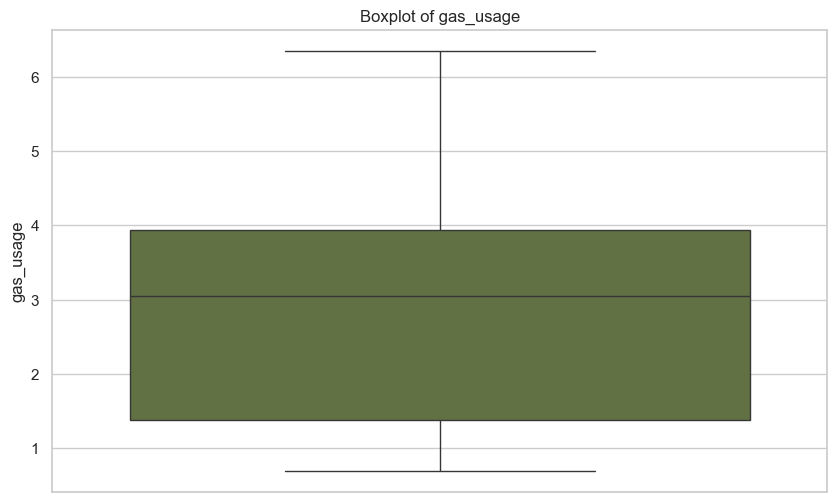

In [842]:
# Create a boxplot to visualize the distribution of 'gas_usage' after log transformation
plt.figure(figsize=(10, 6)) 
sns.boxplot(data=df_processed, y='gas_usage', color=color)  
plt.title('Boxplot of gas_usage')  
plt.ylabel('gas_usage')  
plt.show()  

>As we can observe in the box plot, the log transformation successfully handled the outliers in the `gas_usage` feature, placing all the values within the whiskers.

##### **Handling outliers in `age`**

In [843]:
# Calculate the first quartile (Q1) for 'age'
Q1 = df_processed['age'].quantile(0.25)

# Calculate the third quartile (Q3) for 'age'
Q3 = df_processed['age'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the upper limit for outliers in 'age'
age_upper_limit = Q3 + 1.5 * IQR

# Identify outliers in 'age' that are above the upper limit
age_outliers = df_processed[df_processed['age'] > age_upper_limit]

# Count the number of outliers in 'age'
age_outliers_count = age_outliers.shape[0]

# Print the number of outliers
print(f"Number of outliers in 'age': {age_outliers_count}")

Number of outliers in 'age': 191


>Although there are only **191** outliers in the `age` feature, we decided to **keep them** as they are valid values, and removing them could lead to a loss of information.

##### Handling outliers in `income`

In [844]:
# Calculate the first quartile (Q1) for 'income'
Q1 = df_processed['income'].quantile(0.25)

# Calculate the third quartile (Q3) for 'income'
Q3 = df_processed['income'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the upper limit for outliers in 'income'
income_upper_limit = Q3 + 1.5 * IQR

# Identify outliers in 'income' that are above the upper limit
income_outliers = df_processed[df_processed['income'] > income_upper_limit]

# Count the number of outliers in 'income'
income_outliers_count = income_outliers.shape[0]

# Print the number of outliers
print(f"Number of outliers in 'income': {income_outliers_count}")

Number of outliers in 'income': 4512


>There are **4512** outliers in the `income` feature. As in the gas_usage feature, we will apply a **log transformation** to the `income` feature to handle the outliers, but in this case, as we have negative, zero, and positive values, we will **add an offset**, equal to the absolute value of the minimum value in the feature, to avoid issues with the log transformation.

In [845]:
min_value = df_processed['income'].min()
offset = abs(min_value) + 1  # Ensure all values > 0
df_processed['income'] = np.log(df_processed['income'] + offset)

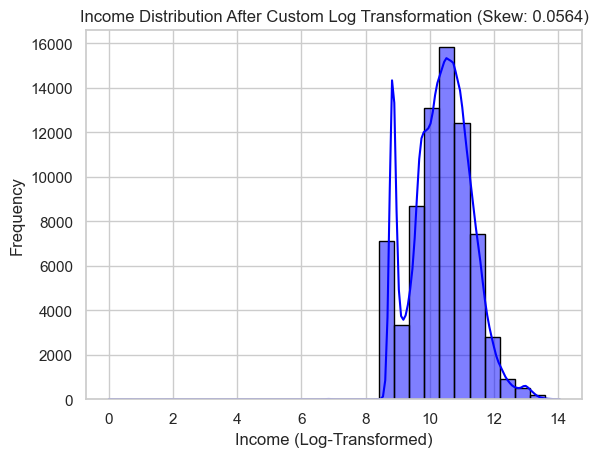

In [846]:
# Plot the distribution after log transformation
sns.histplot(df_processed['income'], kde=True, bins=30, color='blue', edgecolor='black')
plt.title(f'Income Distribution After Custom Log Transformation (Skew: {df_processed["income"].skew():.4f})')
plt.xlabel('Income (Log-Transformed)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

>As we can observe in the income distribution plot after the log transformation, the outliers were successfully handled, with a skew value close to zero (**0.0564**).

#### **Encoding Categorical Variables**

To build the model, it is essential to encode the categorical variables, as most machine learning algorithms require numerical input. 

In [847]:
# Define mappings for categorical variables
sex_mapping = {'Female': 0, 'Male': 1}
is_employed_mapping = {False: 0, True: 1, 'Not in Workforce': 2}
marital_status_mapping = {'Divorced/Separated': 0, 'Married': 1, 'Never married': 2, 'Widowed': 3}
housing_type_mapping = {'Homeowner free and clear': 0, 'Homeowner with mortgage/loan': 1, 'Occupied with no rent': 2, 'Rented': 3, 'Unknown': 4}
recent_move_b_mapping = {'F': 0, 'T': 1, 'Unknown': 2}
health_ins_mapping = {False: 0, True: 1}

# Apply mappings to the DataFrame
df_processed['sex'] = df_processed['sex'].map(sex_mapping)  
df_processed['is_employed'] = df_processed['is_employed'].map(is_employed_mapping)  
df_processed['marital_status'] = df_processed['marital_status'].map(marital_status_mapping)  
df_processed['housing_type'] = df_processed['housing_type'].map(housing_type_mapping)  
df_processed['recent_move_b'] = df_processed['recent_move_b'].map(recent_move_b_mapping)  
df_processed['health_ins'] = df_processed['health_ins'].map(health_ins_mapping)  

# Initialize LabelEncoders for other categorical variables
state_of_res_le = LabelEncoder()

# Apply LabelEncoders to the DataFrame
df_processed['state_of_res'] = state_of_res_le.fit_transform(df_processed['state_of_res'])  

df_processed.head()

sex  is_employed     income  marital_status  health_ins  housing_type  \
0    1            1  10.271631               2           1             0   
1    0            2  10.312314               0           1             3   
2    0            1  10.236418               2           1             1   
3    0            2  10.707080               3           1             0   
4    1            1  10.734242               0           1             3   

   num_vehicles  age  state_of_res  gas_usage  rooms  recent_move_b  
0           0.0   24             0   5.351858      3              0  
1           0.0   82             0   1.386294      6              1  
2           2.0   31             0   3.713572      3              0  
3           1.0   93             0   4.795791      2              0  
4           2.0   67             0   1.386294      2              0

#### **Splitting the dataset into training and testing sets**

The last step in data preparation is to split the dataset into training and testing sets. We will use **80%** of the data for training and **20%** for testing.

In [848]:
# Split the dataset into training and testing sets
X = df_processed.drop(columns=['health_ins'], errors='ignore')
y = df_processed['health_ins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

---

## **Modeling**

As we observed in the data understanding phase, the dataset is imbalanced, with **65553** people having health insurance and **6905** people not having health insurance.

We will consider the **balanced** and **non-balanced** dataset versions as two separate problems. 

### **Non-Balanced Dataset - Modeling**

In [849]:
# Nearest Neighbor Classifier with cross-validation
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
print("Nearest Neighbor Classifier Evaluation:")
print(classification_report(y_test, knn_predictions))
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_precision_0 = precision_score(y_test, knn_predictions, pos_label=0)
knn_precision_1 = precision_score(y_test, knn_predictions, pos_label=1)
knn_recall_0 = recall_score(y_test, knn_predictions, pos_label=0)
knn_recall_1 = recall_score(y_test, knn_predictions, pos_label=1)
knn_f1_0 = f1_score(y_test, knn_predictions, pos_label=0)
knn_f1_1 = f1_score(y_test, knn_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {knn_scores.mean()}")

Nearest Neighbor Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.89      0.98      0.93        65

    accuracy                           0.88        73
   macro avg       0.44      0.49      0.47        73
weighted avg       0.79      0.88      0.83        73

Mean cross-validated accuracy: 0.8959176624991366


In [850]:
# Bayesian Classifier with cross-validation
nb = GaussianNB()
nb_scores = cross_val_score(nb, X_train, y_train, cv=5, scoring='accuracy')
nb.fit(X_train, y_train)
nb_predictions = nb.predict(X_test)
print("Bayesian Classifier Evaluation:")
print(classification_report(y_test, nb_predictions))
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision_0 = precision_score(y_test, nb_predictions, pos_label=0)
nb_precision_1 = precision_score(y_test, nb_predictions, pos_label=1)
nb_recall_0 = recall_score(y_test, nb_predictions, pos_label=0)
nb_recall_1 = recall_score(y_test, nb_predictions, pos_label=1)
nb_f1_0 = f1_score(y_test, nb_predictions, pos_label=0)
nb_f1_1 = f1_score(y_test, nb_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {nb_scores.mean()}")

Bayesian Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       0.91      0.95      0.93        65

    accuracy                           0.88        73
   macro avg       0.66      0.60      0.62        73
weighted avg       0.86      0.88      0.86        73

Mean cross-validated accuracy: 0.8788423015818194


In [851]:
# Decision Trees with cross-validation
dt = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
dt.fit(X_train, y_train)
dt_predictions = dt.predict(X_test)
print("Decision Trees Evaluation:")
print(classification_report(y_test, dt_predictions))
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision_0 = precision_score(y_test, dt_predictions, pos_label=0)
dt_precision_1 = precision_score(y_test, dt_predictions, pos_label=1)
dt_recall_0 = recall_score(y_test, dt_predictions, pos_label=0)
dt_recall_1 = recall_score(y_test, dt_predictions, pos_label=1)
dt_f1_0 = f1_score(y_test, dt_predictions, pos_label=0)
dt_f1_1 = f1_score(y_test, dt_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {dt_scores.mean()}")

Decision Trees Evaluation:
              precision    recall  f1-score   support

           0       0.11      0.12      0.12         8
           1       0.89      0.88      0.88        65

    accuracy                           0.79        73
   macro avg       0.50      0.50      0.50        73
weighted avg       0.81      0.79      0.80        73

Mean cross-validated accuracy: 0.8462803066933757


In [852]:
# Random Forest Classifier with cross-validation
rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
print("Random Forest Classifier Evaluation:")
print(classification_report(y_test, rf_predictions))
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision_0 = precision_score(y_test, rf_predictions, pos_label=0)
rf_precision_1 = precision_score(y_test, rf_predictions, pos_label=1)
rf_recall_0 = recall_score(y_test, rf_predictions, pos_label=0)
rf_recall_1 = recall_score(y_test, rf_predictions, pos_label=1)
rf_f1_0 = f1_score(y_test, rf_predictions, pos_label=0)
rf_f1_1 = f1_score(y_test, rf_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {rf_scores.mean()}")

Random Forest Classifier Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.90      1.00      0.95        65

    accuracy                           0.90        73
   macro avg       0.95      0.56      0.59        73
weighted avg       0.91      0.90      0.87        73

Mean cross-validated accuracy: 0.904593493127029


In [853]:
# Support Vector Machines
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
svc_predictions = svc.predict(X_test)
print("Support Vector Machines Evaluation:")
print(classification_report(y_test, svc_predictions))
svc_accuracy = accuracy_score(y_test, svc_predictions)
svc_precision_0 = precision_score(y_test, svc_predictions, pos_label=0)
svc_precision_1 = precision_score(y_test, svc_predictions, pos_label=1)
svc_recall_0 = recall_score(y_test, svc_predictions, pos_label=0)
svc_recall_1 = recall_score(y_test, svc_predictions, pos_label=1)
svc_f1_0 = f1_score(y_test, svc_predictions, pos_label=0)
svc_f1_1 = f1_score(y_test, svc_predictions, pos_label=1)

Support Vector Machines Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.89      1.00      0.94        65

    accuracy                           0.89        73
   macro avg       0.45      0.50      0.47        73
weighted avg       0.79      0.89      0.84        73



In [854]:
# XGBoost Classifier with cross-validation
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy')
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)
print("XGBoost Classifier Evaluation:")
print(classification_report(y_test, xgb_predictions))
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision_0 = precision_score(y_test, xgb_predictions, pos_label=0)
xgb_precision_1 = precision_score(y_test, xgb_predictions, pos_label=1)
xgb_recall_0 = recall_score(y_test, xgb_predictions, pos_label=0)
xgb_recall_1 = recall_score(y_test, xgb_predictions, pos_label=1)
xgb_f1_0 = f1_score(y_test, xgb_predictions, pos_label=0)
xgb_f1_1 = f1_score(y_test, xgb_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {xgb_scores.mean()}")

XGBoost Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.90      0.98      0.94        65

    accuracy                           0.89        73
   macro avg       0.70      0.55      0.57        73
weighted avg       0.86      0.89      0.86        73

Mean cross-validated accuracy: 0.9052289839055053


In [855]:
# Neural Network Classifier
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
mlp_predictions = mlp.predict(X_test)
print("Neural Network Classifier Evaluation:")
print(classification_report(y_test, mlp_predictions))
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
mlp_precision_0 = precision_score(y_test, mlp_predictions, pos_label=0)
mlp_precision_1 = precision_score(y_test, mlp_predictions, pos_label=1)
mlp_recall_0 = recall_score(y_test, mlp_predictions, pos_label=0)
mlp_recall_1 = recall_score(y_test, mlp_predictions, pos_label=1)
mlp_f1_0 = f1_score(y_test, mlp_predictions, pos_label=0)
mlp_f1_1 = f1_score(y_test, mlp_predictions, pos_label=1)

Neural Network Classifier Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.90      1.00      0.95        65

    accuracy                           0.90        73
   macro avg       0.95      0.56      0.59        73
weighted avg       0.91      0.90      0.87        73



In [856]:
# Store the metrics in a dictionary
models = {
    "Nearest Neighbor": {
        "Accuracy": knn_accuracy,
        "Precision Class 0": knn_precision_0,
        "Precision Class 1": knn_precision_1,
        "Recall Class 0": knn_recall_0,
        "Recall Class 1": knn_recall_1,
        "F1 Score Class 0": knn_f1_0,
        "F1 Score Class 1": knn_f1_1
    },
    "Bayesian Classifier": {
        "Accuracy": nb_accuracy,
        "Precision Class 0": nb_precision_0,
        "Precision Class 1": nb_precision_1,
        "Recall Class 0": nb_recall_0,
        "Recall Class 1": nb_recall_1,
        "F1 Score Class 0": nb_f1_0,
        "F1 Score Class 1": nb_f1_1
    },
    "Decision Trees": {
        "Accuracy": dt_accuracy,
        "Precision Class 0": dt_precision_0,
        "Precision Class 1": dt_precision_1,
        "Recall Class 0": dt_recall_0,
        "Recall Class 1": dt_recall_1,
        "F1 Score Class 0": dt_f1_0,
        "F1 Score Class 1": dt_f1_1
    },
    "Random Forest": {
        "Accuracy": rf_accuracy,
        "Precision Class 0": rf_precision_0,
        "Precision Class 1": rf_precision_1,
        "Recall Class 0": rf_recall_0,
        "Recall Class 1": rf_recall_1,
        "F1 Score Class 0": rf_f1_0,
        "F1 Score Class 1": rf_f1_1
    },
    "Support Vector Machines": {
        "Accuracy": svc_accuracy,
        "Precision Class 0": svc_precision_0,
        "Precision Class 1": svc_precision_1,
        "Recall Class 0": svc_recall_0,
        "Recall Class 1": svc_recall_1,
        "F1 Score Class 0": svc_f1_0,
        "F1 Score Class 1": svc_f1_1
    },
    "XGBoost": {
        "Accuracy": xgb_accuracy,
        "Precision Class 0": xgb_precision_0,
        "Precision Class 1": xgb_precision_1,
        "Recall Class 0": xgb_recall_0,
        "Recall Class 1": xgb_recall_1,
        "F1 Score Class 0": xgb_f1_0,
        "F1 Score Class 1": xgb_f1_1
    },
    "Neural Network": {
        "Accuracy": mlp_accuracy,
        "Precision Class 0": mlp_precision_0,
        "Precision Class 1": mlp_precision_1,
        "Recall Class 0": mlp_recall_0,
        "Recall Class 1": mlp_recall_1,
        "F1 Score Class 0": mlp_f1_0,
        "F1 Score Class 1": mlp_f1_1
    }
}

comparison_df = pd.DataFrame(models).T.reset_index()
comparison_df.columns = ['Model', 'Accuracy', 'Precision Class 0', 'Precision Class 1', 'Recall Class 0', 'Recall Class 1', 'F1 Score Class 0', 'F1 Score Class 1']
comparison_df = comparison_df.sort_values(by='Accuracy', ascending=False)

styled_comparison_df = comparison_df.style \
    .format(precision=3) \
    .format_index(str.upper, axis=1) \
    .set_table_styles(
        [{'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), ('color', '#333'), ('font-weight', 'bold')]},
         {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f9f9f9'), ('color', '#000')]},
         {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#ffffff'), ('color', '#000')]}]
    ).set_properties(**{'text-align': 'center', 'color': '#000'})

styled_comparison_df

### **Balanced Dataset - Modeling**

To handle the class imbalance, there are several techniques we can use.  

#### **Resampling Techniques**

To address the class imbalance, we tested various resampling techniques: **oversampling**, **undersampling**, and a **combination of both**.

After testing the different resampling techniques, we decided to keep two of them as they showed the best performance: **SMOTETomek** and **SMOTETomek + EditedNearestNeighbours**.

This following code visualizes the impact of three **resampling techniques** (SMOTE, SMOTEENN, SMOTETomek) on **class distribution** and **decision boundaries** of a **RandomForestClassifier**. The dataset is standardized and reduced to **2 dimensions** using **PCA** for visualization. Each subplot shows the classifier's decision boundary and the resampled training data distribution.

Class distribution after resampling with SMOTE: Counter({1: 45887, 0: 45887})
Class distribution after resampling with SMOTEENN: Counter({0: 27135, 1: 24670})
Class distribution after resampling with SMOTETomek: Counter({1: 40973, 0: 40973})


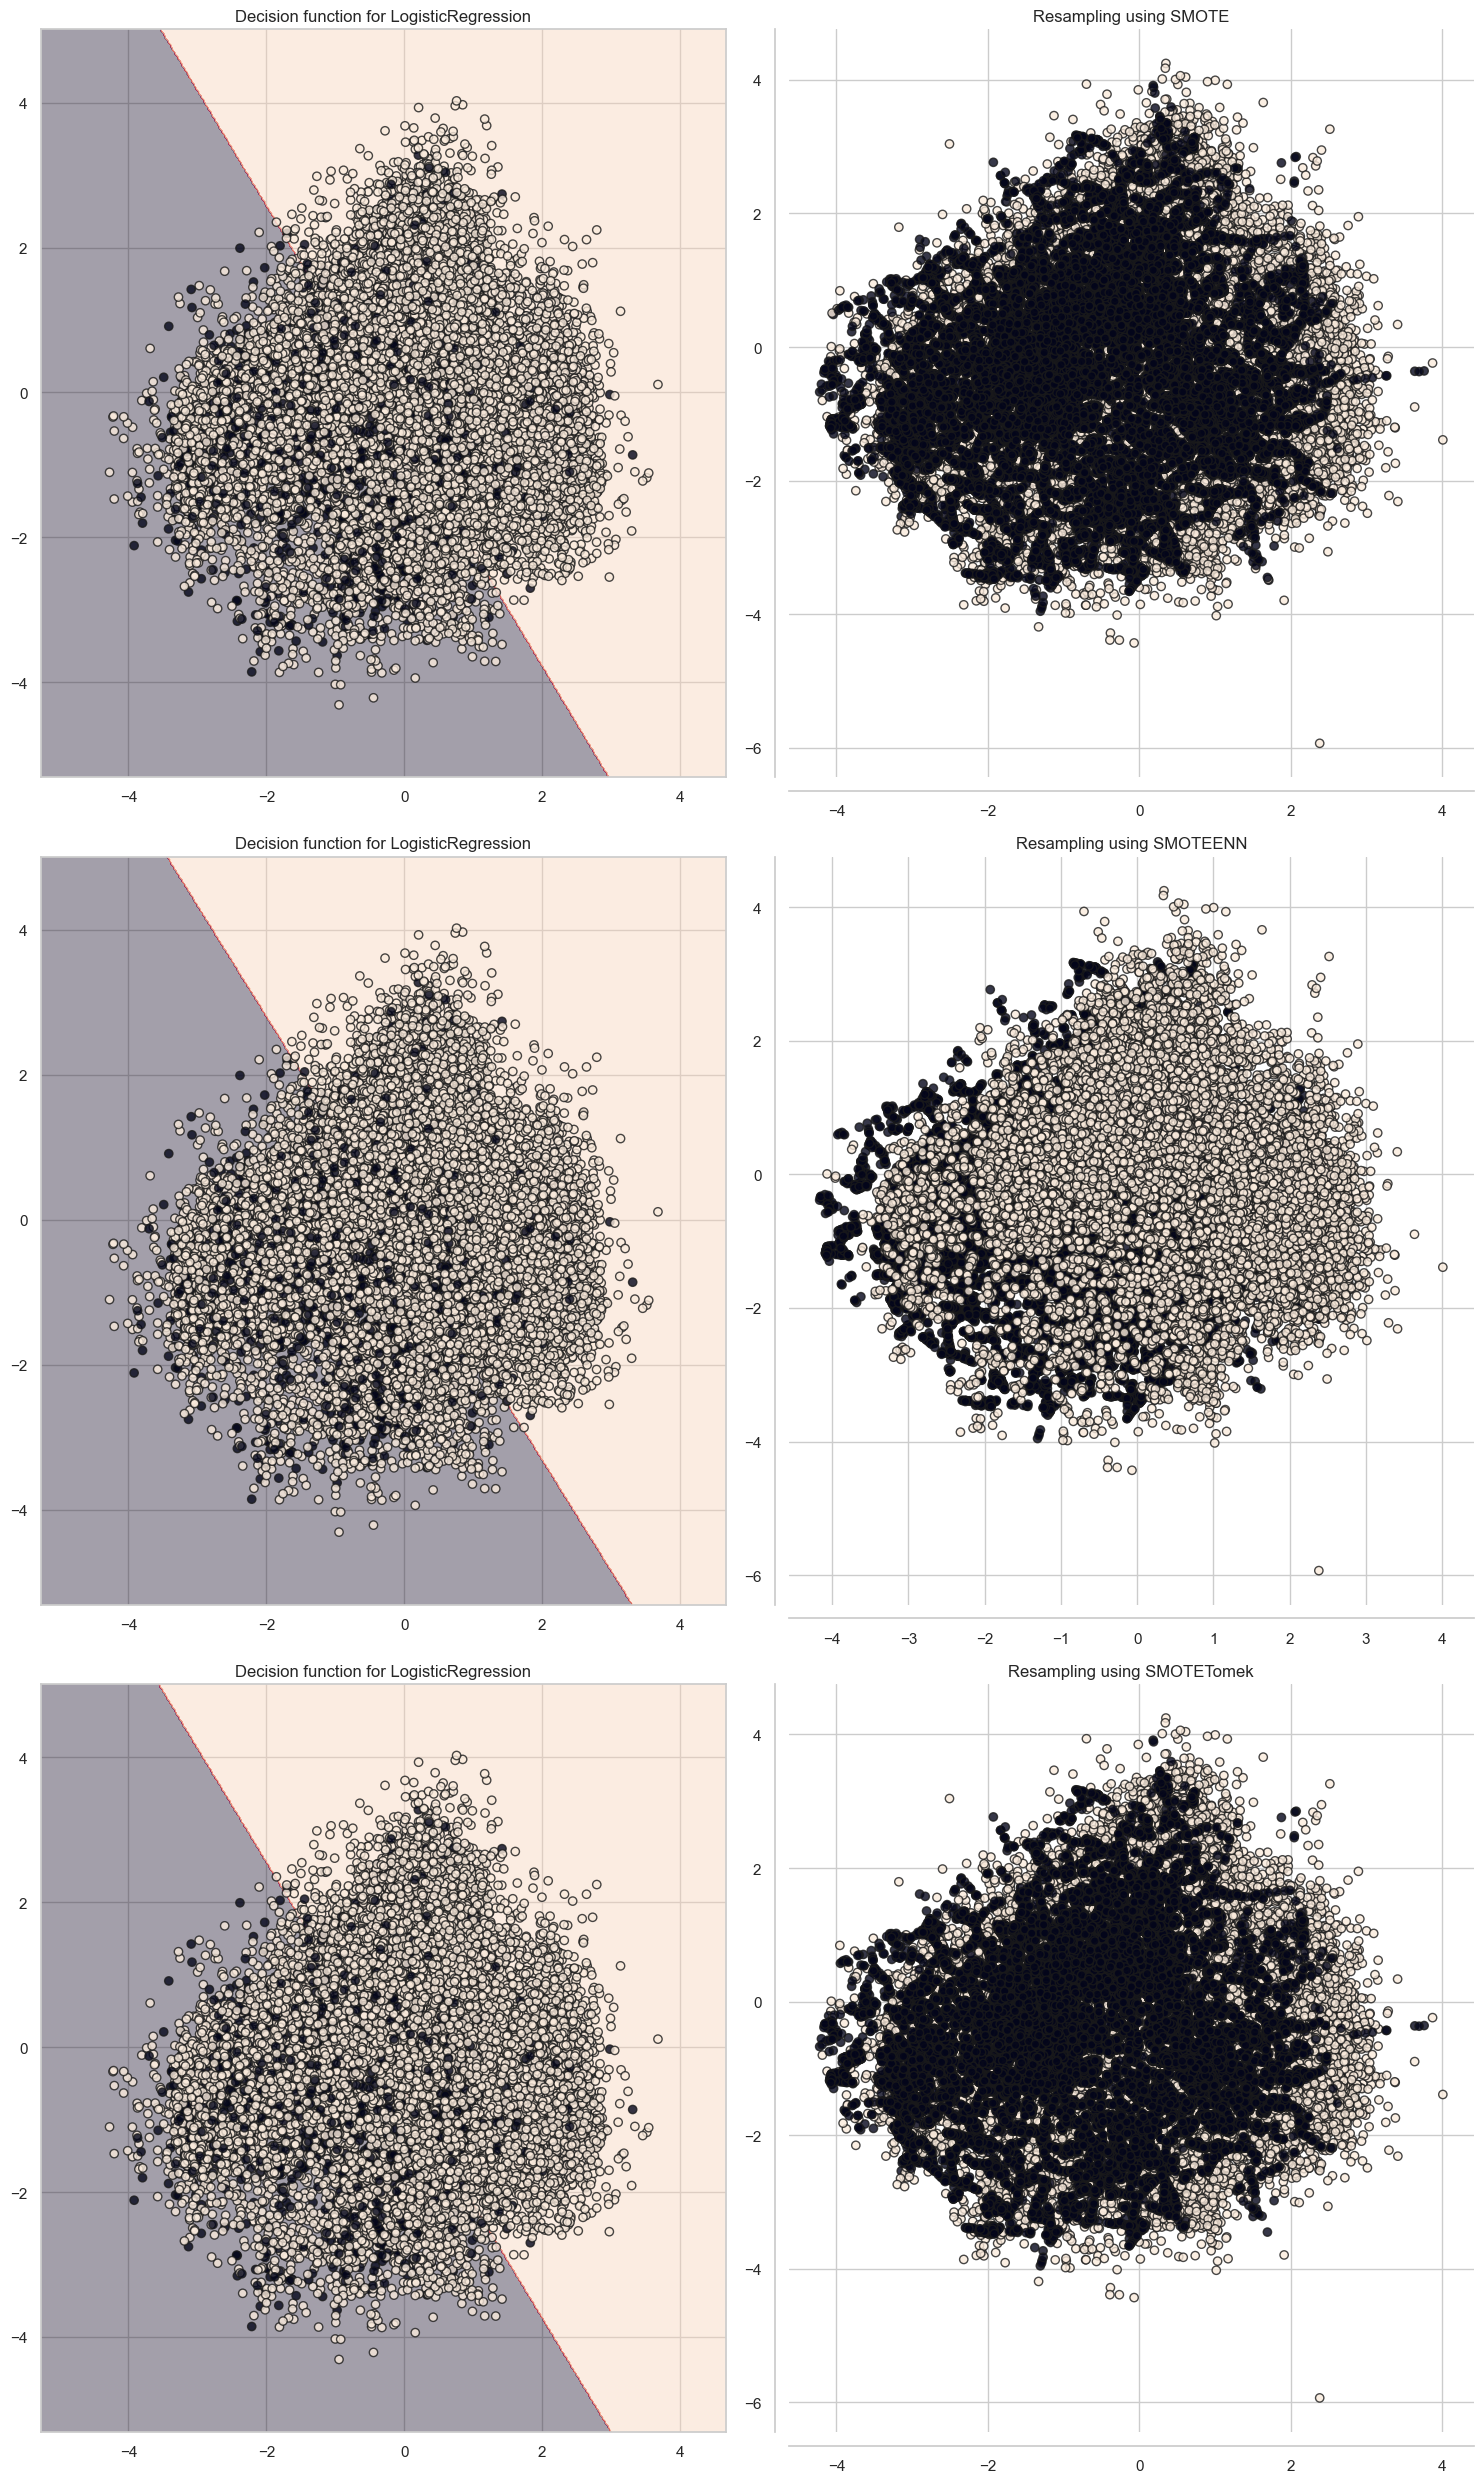

In [857]:
# Define helper functions for plotting
def plot_resampling(X, y, sampler, ax):
    """Plot the resampled dataset using the sampler."""
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    sns.despine(ax=ax, offset=10)
    ax.set_title(f"Resampling using {sampler.__class__.__name__}")
    return Counter(y_res)

def plot_decision_function(X, y, clf, ax):
    """Plot the decision function of the classifier and the original data"""
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    ax.set_title(f"Decision function for {clf.steps[-1][1].__class__.__name__}")

X_test_copy = X_test.copy()

# Standardize the data
scaler = StandardScaler()
df_processed_scaled = scaler.fit_transform(df_processed.drop(columns=['health_ins']))

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
df_processed_pca = pca.fit_transform(df_processed_scaled)

# Split the data into training and testing sets
X_copy = df_processed_pca
y_copy = df_processed['health_ins'].values
X_train_copy, X_test_copy, y_train_copy, y_test_copy = train_test_split(X_copy, y_copy, test_size=0.3, random_state=42, stratify=y_copy)

# Define samplers
samplers = [SMOTE(random_state=42), SMOTEENN(random_state=42), SMOTETomek(random_state=42)]
sampler_names = ["SMOTE", "SMOTEENN", "SMOTETomek"]

fig, axs = plt.subplots(3, 2, figsize=(15, 25))

for ax, sampler, name in zip(axs, samplers, sampler_names):
    clf = Pipeline(steps=[('sampler', sampler), ('classifier', LogisticRegression(random_state=42))])
    clf.fit(X_train_copy, y_train_copy)
    plot_decision_function(X_test_copy, y_test_copy, clf, ax[0])
    class_distribution = plot_resampling(X_train_copy, y_train_copy, sampler, ax[1])
    print(f"Class distribution after resampling with {name}: {class_distribution}")

fig.tight_layout()
plt.show()

##### **SMOTETomek**

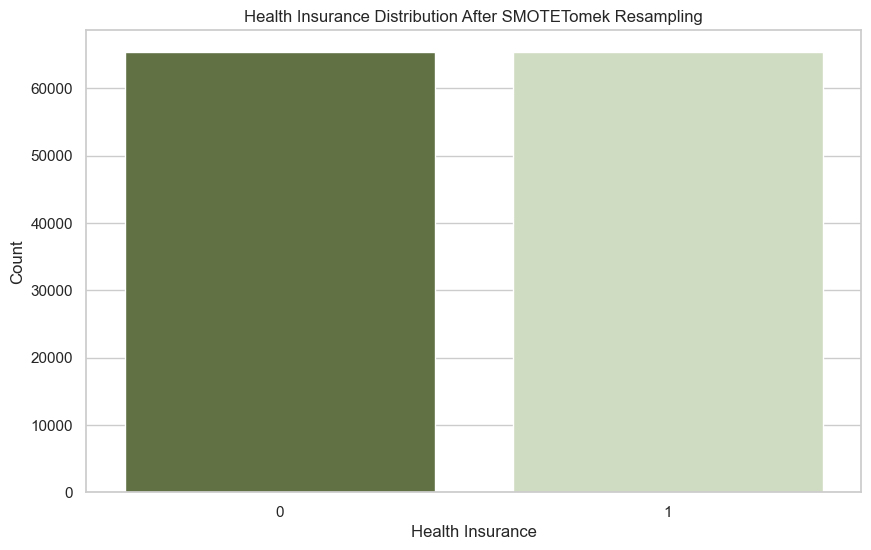

In [858]:
# Apply SMOTETomek to the training dataset
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Plot the target class distribution after resampling
plt.figure(figsize=(10, 6))
sns.countplot(x=y_resampled, palette=custom_palette)
plt.title('Health Insurance Distribution After SMOTETomek Resampling')
plt.xlabel('Health Insurance')
plt.ylabel('Count')
plt.show()

##### **SMOTETomek + EditedNearestNeighbours**

In [859]:
# Define the combined resampling techniques
sampler_list = [
    ('smotetomek', SMOTETomek(random_state=42)),  # Oversampling with SMOTETomek
    ('enn', EditedNearestNeighbours(n_neighbors=5))  # Cleaning with Edited Nearest Neighbours
]

# Create the pipeline for resampling
resampling_pipeline = Pipeline(sampler_list)

# Apply the pipeline on the training data
X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)

# Display the class distribution after resampling
print(f"Class distribution after combined resampling: {Counter(y_resampled)}")


Class distribution after combined resampling: Counter({0: 65372, 1: 36008})


#### **Modeling with Resampled Data**

In [860]:
# Nearest Neighbor Classifier with cross-validation
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_resampled, y_resampled, cv=5, scoring='accuracy')
knn.fit(X_resampled, y_resampled)
knn_predictions = knn.predict(X_test)
print("Nearest Neighbor Classifier Evaluation:")
print(classification_report(y_test, knn_predictions))
knn_accuracy_resampled = accuracy_score(y_test, knn_predictions)
knn_precision_resampled_0 = precision_score(y_test, knn_predictions, pos_label=0)
knn_precision_resampled_1 = precision_score(y_test, knn_predictions, pos_label=1)
knn_recall_resampled_0 = recall_score(y_test, knn_predictions, pos_label=0)
knn_recall_resampled_1 = recall_score(y_test, knn_predictions, pos_label=1)
knn_f1_resampled_0 = f1_score(y_test, knn_predictions, pos_label=0)
knn_f1_resampled_1 = f1_score(y_test, knn_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {knn_scores.mean()}")

Nearest Neighbor Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.23      1.00      0.37         8
           1       1.00      0.58      0.74        65

    accuracy                           0.63        73
   macro avg       0.61      0.79      0.55        73
weighted avg       0.92      0.63      0.70        73

Mean cross-validated accuracy: 0.727520220950878


In [861]:
# Bayesian Classifier with cross-validation
nb = GaussianNB()
nb_scores = cross_val_score(nb, X_resampled, y_resampled, cv=5, scoring='accuracy')
nb.fit(X_resampled, y_resampled)
nb_predictions = nb.predict(X_test)
print("Bayesian Classifier Evaluation:")
print(classification_report(y_test, nb_predictions))
nb_accuracy_resampled = accuracy_score(y_test, nb_predictions)
nb_precision_resampled_0 = precision_score(y_test, nb_predictions, pos_label=0)
nb_precision_resampled_1 = precision_score(y_test, nb_predictions, pos_label=1)
nb_recall_resampled_0 = recall_score(y_test, nb_predictions, pos_label=0)
nb_recall_resampled_1 = recall_score(y_test, nb_predictions, pos_label=1)
nb_f1_resampled_0 = f1_score(y_test, nb_predictions, pos_label=0)
nb_f1_resampled_1 = f1_score(y_test, nb_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {nb_scores.mean()}")

Bayesian Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.21      1.00      0.35         8
           1       1.00      0.54      0.70        65

    accuracy                           0.59        73
   macro avg       0.61      0.77      0.52        73
weighted avg       0.91      0.59      0.66        73

Mean cross-validated accuracy: 0.8165219964490037


In [862]:
# Decision Trees with cross-validation
dt = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt, X_resampled, y_resampled, cv=5, scoring='accuracy')
dt.fit(X_resampled, y_resampled)
dt_predictions = dt.predict(X_test)
print("Decision Trees Evaluation:")
print(classification_report(y_test, dt_predictions))
dt_accuracy_resampled = accuracy_score(y_test, dt_predictions)
dt_precision_resampled_0 = precision_score(y_test, dt_predictions, pos_label=0)
dt_precision_resampled_1 = precision_score(y_test, dt_predictions, pos_label=1)
dt_recall_resampled_0 = recall_score(y_test, dt_predictions, pos_label=0)
dt_recall_resampled_1 = recall_score(y_test, dt_predictions, pos_label=1)
dt_f1_resampled_0 = f1_score(y_test, dt_predictions, pos_label=0)
dt_f1_resampled_1 = f1_score(y_test, dt_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {dt_scores.mean()}")

Decision Trees Evaluation:
              precision    recall  f1-score   support

           0       0.36      1.00      0.53         8
           1       1.00      0.78      0.88        65

    accuracy                           0.81        73
   macro avg       0.68      0.89      0.71        73
weighted avg       0.93      0.81      0.84        73

Mean cross-validated accuracy: 0.7529887551785361


In [863]:
# Random Forest Classifier with cross-validation
rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='accuracy')
rf.fit(X_resampled, y_resampled)
rf_predictions = rf.predict(X_test)
print("Random Forest Classifier Evaluation:")
print(classification_report(y_test, rf_predictions))
rf_accuracy_resampled = accuracy_score(y_test, rf_predictions)
rf_precision_resampled_0 = precision_score(y_test, rf_predictions, pos_label=0)
rf_precision_resampled_1 = precision_score(y_test, rf_predictions, pos_label=1)
rf_recall_resampled_0 = recall_score(y_test, rf_predictions, pos_label=0)
rf_recall_resampled_1 = recall_score(y_test, rf_predictions, pos_label=1)
rf_f1_resampled_0 = f1_score(y_test, rf_predictions, pos_label=0)
rf_f1_resampled_1 = f1_score(y_test, rf_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {rf_scores.mean()}")

Random Forest Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         8
           1       1.00      0.82      0.90        65

    accuracy                           0.84        73
   macro avg       0.70      0.91      0.73        73
weighted avg       0.93      0.84      0.86        73

Mean cross-validated accuracy: 0.7701913592424542


In [864]:
# XGBoost Classifier with cross-validation
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_scores = cross_val_score(xgb, X_resampled, y_resampled, cv=5, scoring='accuracy')
xgb.fit(X_resampled, y_resampled)
xgb_predictions = xgb.predict(X_test)
print("XGBoost Classifier Evaluation:")
print(classification_report(y_test, xgb_predictions))
xgb_accuracy_resampled = accuracy_score(y_test, xgb_predictions)
xgb_precision_resampled_0 = precision_score(y_test, xgb_predictions, pos_label=0)
xgb_precision_resampled_1 = precision_score(y_test, xgb_predictions, pos_label=1)
xgb_recall_resampled_0 = recall_score(y_test, xgb_predictions, pos_label=0)
xgb_recall_resampled_1 = recall_score(y_test, xgb_predictions, pos_label=1)
xgb_f1_resampled_0 = f1_score(y_test, xgb_predictions, pos_label=0)
xgb_f1_resampled_1 = f1_score(y_test, xgb_predictions, pos_label=1)
print(f"Mean cross-validated accuracy: {xgb_scores.mean()}")

XGBoost Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.42      1.00      0.59         8
           1       1.00      0.83      0.91        65

    accuracy                           0.85        73
   macro avg       0.71      0.92      0.75        73
weighted avg       0.94      0.85      0.87        73

Mean cross-validated accuracy: 0.6869303610179522


In [865]:
# Neural Network Classifier
mlp = MLPClassifier(random_state=42)
mlp.fit(X_resampled, y_resampled)
mlp_predictions = mlp.predict(X_test)
print("Neural Network Classifier Evaluation:")
print(classification_report(y_test, mlp_predictions))
mlp_accuracy_resampled = accuracy_score(y_test, mlp_predictions)
mlp_precision_resampled_0 = precision_score(y_test, mlp_predictions, pos_label=0)
mlp_precision_resampled_1 = precision_score(y_test, mlp_predictions, pos_label=1)
mlp_recall_resampled_0 = recall_score(y_test, mlp_predictions, pos_label=0)
mlp_recall_resampled_1 = recall_score(y_test, mlp_predictions, pos_label=1)
mlp_f1_resampled_0 = f1_score(y_test, mlp_predictions, pos_label=0)
mlp_f1_resampled_1 = f1_score(y_test, mlp_predictions, pos_label=1)

Neural Network Classifier Evaluation:
              precision    recall  f1-score   support

           0       0.23      1.00      0.37         8
           1       1.00      0.58      0.74        65

    accuracy                           0.63        73
   macro avg       0.61      0.79      0.55        73
weighted avg       0.92      0.63      0.70        73



In [866]:
# Store the metrics in a dictionary
models = {
    "Nearest Neighbor": {
        "Accuracy": knn_accuracy_resampled,
        "Precision Class 0": knn_precision_resampled_0,
        "Precision Class 1": knn_precision_resampled_1,
        "Recall Class 0": knn_recall_resampled_0,
        "Recall Class 1": knn_recall_resampled_1,
        "F1 Score Class 0": knn_f1_resampled_0,
        "F1 Score Class 1": knn_f1_resampled_1
    },
    "Bayesian Classifier": {
        "Accuracy": nb_accuracy_resampled,
        "Precision Class 0": nb_precision_resampled_0,
        "Precision Class 1": nb_precision_resampled_1,
        "Recall Class 0": nb_recall_resampled_0,
        "Recall Class 1": nb_recall_resampled_1,
        "F1 Score Class 0": nb_f1_resampled_0,
        "F1 Score Class 1": nb_f1_resampled_1
    },
    "Decision Trees": {
        "Accuracy": dt_accuracy_resampled,
        "Precision Class 0": dt_precision_resampled_0,
        "Precision Class 1": dt_precision_resampled_1,
        "Recall Class 0": dt_recall_resampled_0,
        "Recall Class 1": dt_recall_resampled_1,
        "F1 Score Class 0": dt_f1_resampled_0,
        "F1 Score Class 1": dt_f1_resampled_1
    },
    "Random Forest": {
        "Accuracy": rf_accuracy_resampled,
        "Precision Class 0": rf_precision_resampled_0,
        "Precision Class 1": rf_precision_resampled_1,
        "Recall Class 0": rf_recall_resampled_0,
        "Recall Class 1": rf_recall_resampled_1,
        "F1 Score Class 0": rf_f1_resampled_0,
        "F1 Score Class 1": rf_f1_resampled_1
    },
    "XGBoost": {
        "Accuracy": xgb_accuracy_resampled,
        "Precision Class 0": xgb_precision_resampled_0,
        "Precision Class 1": xgb_precision_resampled_1,
        "Recall Class 0": xgb_recall_resampled_0,
        "Recall Class 1": xgb_recall_resampled_1,
        "F1 Score Class 0": xgb_f1_resampled_0,
        "F1 Score Class 1": xgb_f1_resampled_1
    },
    "Neural Network": {
        "Accuracy": mlp_accuracy_resampled,
        "Precision Class 0": mlp_precision_resampled_0,
        "Precision Class 1": mlp_precision_resampled_1,
        "Recall Class 0": mlp_recall_resampled_0,
        "Recall Class 1": mlp_recall_resampled_1,
        "F1 Score Class 0": mlp_f1_resampled_0,
        "F1 Score Class 1": mlp_f1_resampled_1
    }
}

comparison_df = pd.DataFrame(models).T.reset_index()
comparison_df.columns = ['Model', 'Accuracy', 'Precision Class 0', 'Precision Class 1', 'Recall Class 0', 'Recall Class 1', 'F1 Score Class 0', 'F1 Score Class 1']
comparison_df = comparison_df.sort_values(by='Accuracy', ascending=False)

styled_comparison_df = comparison_df.style \
    .format(precision=3) \
    .format_index(str.upper, axis=1) \
    .set_table_styles(
        [{'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), ('color', '#333'), ('font-weight', 'bold')]},
         {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f9f9f9'), ('color', '#000')]},
         {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#ffffff'), ('color', '#000')]}]
    ).set_properties(**{'text-align': 'center', 'color': '#000'})

styled_comparison_df

---

### **Data Preparation on Test Dataset**

In [867]:
# Load the test dataset
df_test = pd.read_csv('../data/customer_test_masked.csv')

df_test.head()

Unnamed: 0        custid     sex is_employed    income marital_status  \
0        4523  001115999_01    Male         NaN   28900.0        Married   
1       58780  000566299_01    Male        True   40000.0  Never married   
2       18628  001397329_01  Female        True  203000.0        Married   
3       11525  000843100_01  Female         NaN       0.0        Married   
4       56266  000260071_03    Male        True   40000.0        Married   

   health_ins                  housing_type  num_vehicles  age state_of_res  \
0         NaN      Homeowner free and clear           1.0   82     Arkansas   
1         NaN                        Rented           1.0   40   New Mexico   
2         NaN  Homeowner with mortgage/loan           3.0   54     Colorado   
3         NaN      Homeowner free and clear           1.0   64   California   
4         NaN  Homeowner with mortgage/loan           4.0   35   New Jersey   

   code_column  gas_usage  rooms recent_move_b  
0          653       20.0      6             F  
1          404       40.0      5             T  
2         1291       80.0      2             F  
3         8962       30.0      2             F  
4         2059      150.0      1             F

In [868]:
# Store the 'custid' feature separately
custid = df_test['custid']

In [869]:
# Drop unnecessary columns
df_test = df_test.drop(columns=['Unnamed: 0', 'custid', 'code_column'], errors='ignore')

In [870]:
# Handle missing values
df_test['is_employed'] = df_test['is_employed'].fillna('Not in Workforce')  # Fill missing employment status with 'Not in Workforce'
df_test['housing_type'] = df_test['housing_type'].fillna(df_test['housing_type'].mode()[0])  # Fill missing housing type with the mode
df_test['num_vehicles'] = df_test['num_vehicles'].fillna(df_test['num_vehicles'].mean().round())  # Fill missing number of vehicles with the mean
df_test['recent_move_b'] = df_test['recent_move_b'].fillna(df_test['recent_move_b'].mode()[0])  # Fill missing recent move status with the mode
df_test['gas_usage'] = df_test['gas_usage'].fillna(df_test['gas_usage'].mean())  # Fill missing gas usage with the mean
df_test['age'] = df_test['age'].replace(0, df_test['age'].mean().round())  # Replace age 0 with the mean age

In [871]:
# Handle outliers
df_test['gas_usage'] = np.log1p(df_test['gas_usage'])  # Apply log transformation to gas usage

min_value = df_test['income'].min()
offset = abs(min_value) + 1  # Ensure all values > 0
df_test['income'] = np.log(df_test['income'] + offset)

In [872]:
# Define mappings for categorical variables
sex_mapping = {'Female': 0, 'Male': 1}
is_employed_mapping = {False: 0, True: 1, 'Not in Workforce': 2}
marital_status_mapping = {'Divorced/Separated': 0, 'Married': 1, 'Never married': 2, 'Widowed': 3}
housing_type_mapping = {'Homeowner free and clear': 0, 'Homeowner with mortgage/loan': 1, 'Occupied with no rent': 2, 'Rented': 3, 'Unknown': 4}
recent_move_b_mapping = {'F': 0, 'T': 1, 'Unknown': 2}

# Apply mappings to the DataFrame
df_test['sex'] = df_test['sex'].map(sex_mapping)  
df_test['is_employed'] = df_test['is_employed'].map(is_employed_mapping)  
df_test['marital_status'] = df_test['marital_status'].map(marital_status_mapping)  
df_test['housing_type'] = df_test['housing_type'].map(housing_type_mapping)  
df_test['recent_move_b'] = df_test['recent_move_b'].map(recent_move_b_mapping)  

# Initialize LabelEncoders for other categorical variables
state_of_res_le = LabelEncoder()

# Apply LabelEncoders to the DataFrame
df_test['state_of_res'] = state_of_res_le.fit_transform(df_test['state_of_res'])  

df_test.head()

sex  is_employed     income  marital_status  health_ins  housing_type  \
0    1            2  10.271631               1         NaN             0   
1    1            1  10.596660               2         NaN             3   
2    0            1  12.220966               1         NaN             1   
3    0            2   0.000000               1         NaN             0   
4    1            1  10.596660               1         NaN             1   

   num_vehicles  age  state_of_res  gas_usage  rooms  recent_move_b  
0           1.0   82             3   3.044522      6              0  
1           1.0   40            30   3.713572      5              1  
2           3.0   54             5   4.394449      2              0  
3           1.0   64             4   3.433987      2              0  
4           4.0   35            29   5.017280      1              0

In [873]:
# Drop the target variable in the test set
X_test_final = df_test.drop(columns=['health_ins'], errors='ignore')

### Training the XGBoost Model with the Resampled Data

In [874]:
# Initialize the XGBoost classifier with RandomizedSearchCV
xgb_classifier = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
)

# Fit the model using the resampled training data
xgb_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test data
xgb_predictions = xgb_classifier.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, xgb_predictions, average='weighted')

print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.21      1.00      0.35         8
           1       1.00      0.54      0.70        65

    accuracy                           0.59        73
   macro avg       0.61      0.77      0.52        73
weighted avg       0.91      0.59      0.66        73



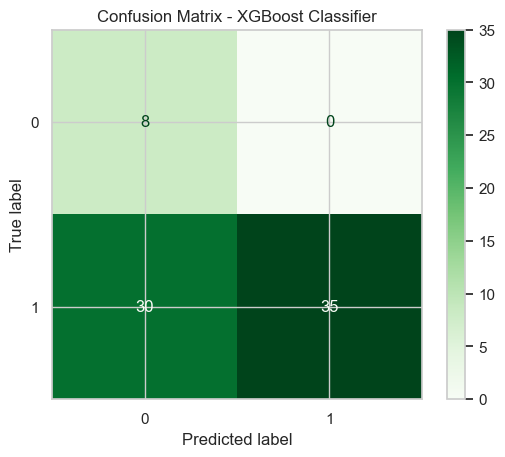

In [875]:
# Confusion matrix
cm = confusion_matrix(y_test, xgb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()

 > Even after balancing the dataset, we still decided to add the scale_pos_weight parameter, which is not used by default in a standard XGBoost. However, after several tests, we noticed that the results were better with it.

### Find the Optimal Threshold

In [876]:
y_probs = xgb_classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

f1_scores = 2 * recall * precision / (recall + precision)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

print(f"Optimal Threshold: {optimal_threshold}")

print(classification_report(y_test, y_pred_optimal))

Optimal Threshold: 0.004259215667843819
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.92      1.00      0.96        65

    accuracy                           0.92        73
   macro avg       0.96      0.62      0.68        73
weighted avg       0.92      0.92      0.89        73



Not satisfied with the submitted results, we analyzed what could be changed to improve. Then, with our best model:
   - We used `predict_proba`, which returns the predicted probabilities;
   - Calculated the **F1-Score** for each **Threshold**;
   - Selected the best Threshold and evaluated the results.

### Adapt Threshold

In [877]:
new_threshold = 0.0489 

y_pred_new = (y_probs >= new_threshold).astype(int)

print(f"New Threshold: {new_threshold}")
print(classification_report(y_test, y_pred_new))


New Threshold: 0.0489
              precision    recall  f1-score   support

           0       0.36      0.62      0.45         8
           1       0.95      0.86      0.90        65

    accuracy                           0.84        73
   macro avg       0.65      0.74      0.68        73
weighted avg       0.88      0.84      0.85        73



Nevertheless, with the threshold search, we did not achieve our best result in the submission. We manually adjusted it and arrived at an optimal value of **0.0489**. With this, we used it to convert the probabilities into binary variables.

In [878]:
# 1. Obtain the predicted probabilities for the positive class
y_probs_test = xgb_classifier.predict_proba(X_test_final)[:, 1]

# 2. Apply the optimal threshold to convert probabilities into binary classes
# If you have already determined 'optimal_threshold' based on the validation set
predictions = (y_probs_test >= new_threshold).astype(int)


### **Generating the Submission File with the Predictions for the Test Dataset**

In [879]:
submission = pd.DataFrame({'custid': custid, 'health_ins': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!


---

## Evaluation and Main Conclusions

- After extensive testing, **XGBoost combined with SMOTETomek delivered the best overall performance**, especially in addressing the minority class (individuals without health insurance).
- Models such as **Decision Tree and Random Forest achieved strong results on the training data but struggled to generalize to the test set**, revealing issues with overfitting.
- Given the goal of identifying individuals without health insurance, we recommend prioritizing metrics such as **recall for Class 0** to ensure the model effectively detects this minority group.
- The main challenges included **class imbalance and high overlap between the two classes**, which made classification difficult. To address these, we applied advanced resampling techniques like **SMOTETomek and EditedNearestNeighbours (ENN)** to balance the data and reduce overlapping, improving the model's ability to distinguish between classes.
- The project also involved a comprehensive **data preprocessing pipeline**, including handling missing values, outliers, and skewed data using tailored techniques like **log transformation and mean or mode imputation**. Categorical variables were encoded appropriately to ensure compatibility with the models.
- This project highlights that **classification in real-world datasets can be extremely challenging**, particularly when issues like imbalance, overlapping, and poor data quality are present. Tackling these challenges requires careful preprocessing, experimentation with multiple techniques, and acceptance of inherent trade-offs.
- We learned that while numerous techniques are available to address these issues, **the choice of the most effective approach is often problem-specific and subjective**, requiring a deep understanding of the data and the business goals.
- Overall, the results showcase a complete **data science approach** to solving a challenging real-world problem, providing actionable insights and a scalable process for future projects in similar domains.